# Jet Classification with CNNs

For this tutorial you should use a combination of your lecture notes and the pytorch tutorial at:

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=convolutional

Outline:
 - Imports and plotting set-up
 - Preprocessing jet images
 - Visualising the data
 - Datasets and dataloaders
 - Building the CNN
 - Training the CNN
 - Plot train and validation losses
 - Study the results
 - CNNs and translation invariance
 - Why are CNNs better than fully connected networks here?
     - how many trainable parameters does the CNN have?
     - if you like, build a fully connected network with approximately the same number of parameters as your CNN, train it, and compare the performance to the CNN.
 - How could we improve the results we have here?

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

from helper_preprocessing import constit_to_img

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

## Loading the data

To load the data we'll use the erum-data framework outline is this paper:

https://arxiv.org/pdf/2107.00656.pdf

The erum data python package can be installed using the command below:

`python3 -m pip install git+https://github.com/erum-data-idt/pd4ml`

A notebook showing how to load the top-tagging data using this package can be found here:

https://github.com/erum-data-idt/pd4ml/blob/main/examples/1_top_plots.ipynb

In [3]:
from pd4ml import TopTagging

Erum data includes a desription of the dataset:

In [4]:
TopTagging.print_description()


    Top tagging dataset.

    Description:
    14 TeV, hadronic tops for signal, QCD djets background, Delphes ATLAS detector card with Pythia. No MPI/pile-up included
    Particle-flow entries (produced by Delphes E-flow) have been clustered into anti-kT 0.8 jets in the pT range [550,650].
    All top jets are matched to a parton-level top within ∆R = 0.8, and to all top decay partons within 0.8. Also,|eta|_jet < 2 has been required.

    Ref:
    Deep-learned Top Tagging with a Lorentz Layer by A Butter, G Kasieczka, T and M Russell (arXiv: 1707.08966)

    Dataset shape:
    ~2M events have been stored divided between training (~1.6M) and test (~400k)) and the shape of the dataset is (# of events, 200, 4).
    The feature represent the leading 200 jet constituent four-momenta, with zero-padding for jets that have less than 200.
    Constituents are sorted by pT, with the highest pT one first.

    The second dataset that is included is just a flag "ttv" to identify what the event w

The command below loads the dataset, downloading it if it is not already there.

Warning: these files are large ($\simeq1.5$gb) and downloading them takes some time.

In [5]:
path = '/fs/scratch/PLS0151/particle/dlpp-data/tutorial-3-data/'
X_train_f, y_train_f = TopTagging.load('train', path = path)
X_test_f, y_test_f = TopTagging.load('test', path = path)

In [6]:
X_train_f = X_train_f[0]
X_test_f = X_test_f[0]

In [7]:
print( "shapes:" )
print( "X_train - " + str( np.shape( X_train_f ) ) )
print( "y_train - " + str( np.shape( y_train_f ) ) )
print( "X_test  - " + str( np.shape( X_test_f ) ) )
print( "y_test  - " + str( np.shape( y_test_f ) ) )

shapes:
X_train - (1614000, 200, 4)
y_train - (1614000,)
X_test  - (404000, 200, 4)
y_test  - (404000,)


This is too much for us, let's cut it down.

In [8]:
nj = 30000
X_train = X_train_f[ 0:nj ]
y_train = y_train_f[ 0:nj ]
X_test = X_test_f[ 0:nj ]
y_test = y_test_f[ 0:nj ]
X_val = X_train_f[ -nj: ]
y_val = y_train_f[ -nj: ]

In [9]:
print( "shapes:" )
print( "X_train - " + str( np.shape( X_train ) ) )
print( "y_train - " + str( np.shape( y_train ) ) )
print( "X_test  - " + str( np.shape( X_test ) ) )
print( "y_test  - " + str( np.shape( y_test ) ) )
print( "X_val  - " + str( np.shape( X_val ) ) )
print( "y_val  - " + str( np.shape( y_val ) ) )

shapes:
X_train - (30000, 200, 4)
y_train - (30000,)
X_test  - (30000, 200, 4)
y_test  - (30000,)
X_val  - (30000, 200, 4)
y_val  - (30000,)


Let's save this out so we have the shorter versions in future.

In [10]:
X_train = np.load( path + 'TopTagging/x_train_short.npy')
y_train = np.load( path + 'TopTagging/y_train_short.npy')
X_test = np.load( path + 'TopTagging/x_test_short.npy')
y_test = np.load(path + 'TopTagging/y_test_short.npy')
X_val = np.load( path + 'TopTagging/x_val_short.npy')
y_val = np.load( path + 'TopTagging/y_val_short.npy')

## Preprocessing jet images

We need to convert the jets to $(p_T,\eta,\phi)$ format, preprocessing them with rotations and translations, and convert them to an image format.

We will preprocess the data such that:
- the jets are centred at $(\eta,\phi)=(0.0,0.0)$
- the principle axis of each jet points in the same direction
- the quadrant of the jets with the most $p_T$ is the same for each jet
- the jet $p_T$'s are normalised.

We need some functions for that. Check helper_preprocessing.py for the constit_to_img function.

Now let's run the preprocessing:

In [11]:
z_train = constit_to_img( X_train, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


In [12]:
np.shape( z_train )

(30000, 1600)

In [13]:
z_train[0].sum()

1.0

In [14]:
z_train.sum()

29999.999999999964

In [15]:
z_test = constit_to_img( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


In [16]:
np.shape( z_test )

(30000, 1600)

In [17]:
z_test[0].sum()

1.0

In [18]:
z_test.sum()

30000.000000000065

In [19]:
z_val = constit_to_img( X_val, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


## Visualizing the data

Now let's plot these jet images.

In [20]:
sig = z_train[ np.where(y_train==1) ]
bkg = z_train[ np.where(y_train==0) ]

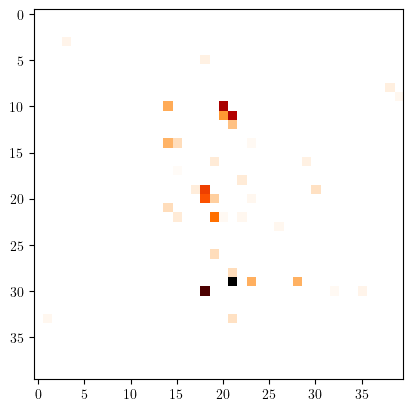

In [21]:
plt.imshow( sig[0].reshape( (40,40) ), cmap="gist_heat_r" )

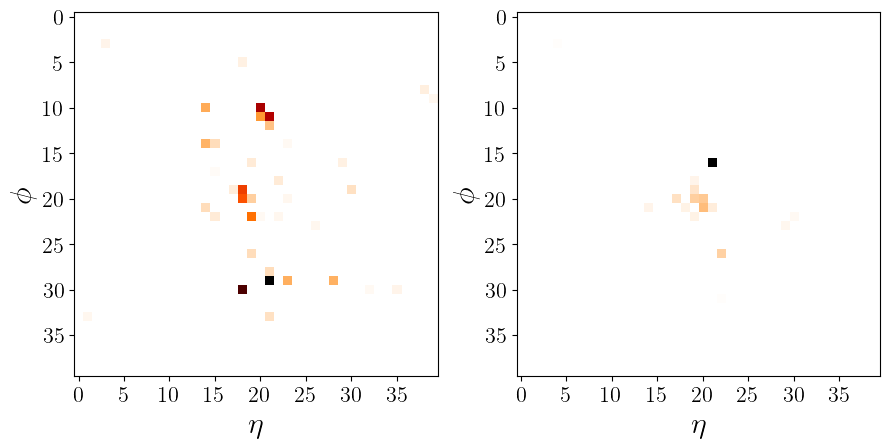

In [22]:
fig, axs = plt.subplots( 1, 2, figsize=(9,5) )

axs[0].imshow( sig[0].reshape( (40,40) ), cmap="gist_heat_r" )
axs[0].set_xlabel( "$\eta$", fontproperties=axislabelfont )
axs[0].set_ylabel( "$\phi$", fontproperties=axislabelfont )
ticks0 = [ int(x) for x in axs[0].get_yticks() ]
axs[0].set_yticklabels( ticks0, fontproperties=tickfont )
axs[0].set_xticklabels( ticks0, fontproperties=tickfont )

axs[1].imshow( bkg[0].reshape( (40,40) ), cmap="gist_heat_r" )
axs[1].set_xlabel( "$\eta$", fontproperties=axislabelfont )
axs[1].set_ylabel( "$\phi$", fontproperties=axislabelfont )
ticks1 = [ int(x) for x in axs[1].get_yticks() ]
axs[1].set_yticklabels( ticks1, fontproperties=tickfont )
axs[1].set_xticklabels( ticks1, fontproperties=tickfont )

fig.tight_layout()

fig.show()

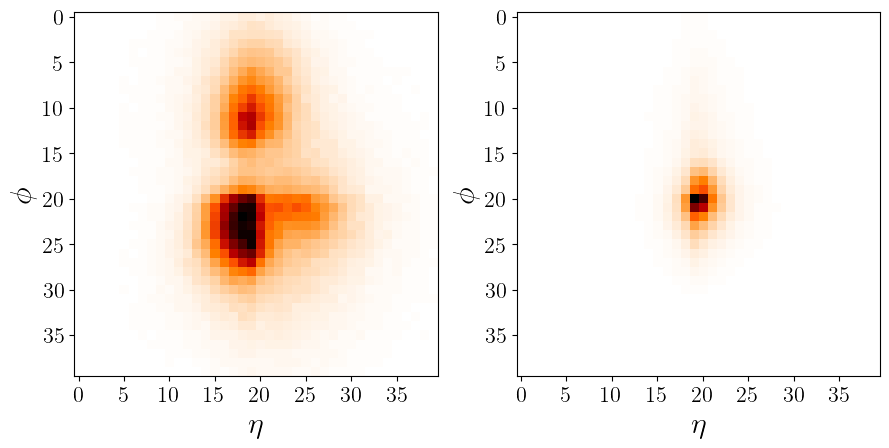

In [23]:
fig, axs = plt.subplots( 1, 2, figsize=(9,5) )

axs[0].imshow( sig.mean(0).reshape( (40,40) ), cmap="gist_heat_r" )
axs[0].set_xlabel( "$\eta$", fontproperties=axislabelfont )
axs[0].set_ylabel( "$\phi$", fontproperties=axislabelfont )
ticks0 = [ int(x) for x in axs[0].get_yticks() ]
axs[0].set_yticklabels( ticks0, fontproperties=tickfont )
axs[0].set_xticklabels( ticks0, fontproperties=tickfont )

axs[1].imshow( bkg.mean(0).reshape( (40,40) ), cmap="gist_heat_r" )
axs[1].set_xlabel( "$\eta$", fontproperties=axislabelfont )
axs[1].set_ylabel( "$\phi$", fontproperties=axislabelfont )
ticks1 = [ int(x) for x in axs[1].get_yticks() ]
axs[1].set_yticklabels( ticks1, fontproperties=tickfont )
axs[1].set_xticklabels( ticks1, fontproperties=tickfont )

fig.tight_layout()

fig.show()

## Datasets and dataloaders

Let's define a minimal dataset similar to the last we have seen.

In [24]:
class cnn_data( Dataset ):
    
    def __init__( self, imgs, labels ):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

Define images and labels as pytorch Tensors, we'll need to call them later.

In [25]:
z_train = torch.Tensor(z_train.reshape(-1, 1, 40,40).astype('float32'))
z_test = torch.Tensor(z_test.reshape(-1, 1, 40,40).astype('float32'))
z_val = torch.Tensor(z_val.reshape(-1, 1, 40,40).astype('float32'))

In [26]:
y_train = torch.Tensor(y_train).unsqueeze(-1)
y_test = torch.Tensor(y_test).unsqueeze(-1)
y_val = torch.Tensor(y_val).unsqueeze(-1)

Finally, create the datasets and the dataloaders:

In [27]:
train_cnn_dataset = cnn_data(z_train, y_train.float())
test_cnn_dataset = cnn_data(z_test, y_test.float())
val_cnn_dataset = cnn_data(z_val, y_val.float())

In [28]:
train_cnn_dataloader = DataLoader( train_cnn_dataset, batch_size=64, shuffle=True )
test_cnn_dataloader = DataLoader( test_cnn_dataset, batch_size=64, shuffle=True )
val_cnn_dataloader = DataLoader( val_cnn_dataset, batch_size=64, shuffle=True)

## Building the CNN

Let's build a simple CNN. We'll use two convolutions with a small number of channels. Two max-pooling layers are introduced to reduce the dimensionality of the images and the parameters of the linear layer.

In [29]:
class ConvNet2D(nn.Module):
    
    def __init__(self, in_ch=1, ch=4, out_dim=1, img_sz=40):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, ch, kernel_size=5, bias=True, stride=1, padding=2)
        self.conv2 = nn.Conv2d(ch, 1, kernel_size=5, bias=True, stride=1, padding=2)
        self.max = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.out = nn.Linear(int(img_sz*img_sz/16), out_dim, bias=True)
        
    def forward(self, x):
        self.net = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.max,
            nn.ReLU(),
            self.conv2,
            self.max,
            self.flatten,
            self.out,
            nn.Sigmoid()
        )
        return self.net(x)
    

Check available device, use GPU if possible:

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Training the CNN

Since our problem is two-class classification problem, we can use the Binary Cross-Entropy as a loss function:

- BCE = $y_i \log p(y_i) + (1-y_i) \log (1-p(y_i)) $

where $y_i$ is the true label, and $p(y_i)$ is the predicted probability of the event being a top jet.

In the loss function we add the log-probability for the correct class. Therefore, increasing the fidelity of a pediction lowers the loss function as desired for an optimization problem.

In [31]:
loss_fn = nn.BCELoss()

In [32]:
def train_epoch( dataloader, model, loss_fn, optimizer ):
    
    size = len( dataloader.dataset )

    for batch, (X, y) in enumerate(dataloader):

        # pass data through network
        pred = model(X.to(device))
        
        # compute loss
        loss = loss_fn( pred, y.to(device) )

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print( f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]" )

In [33]:
def val_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X.to(device) )
            vl += loss_fn( pred, y.to(device) ).item()

    vl /= num_batches
    print( f"avg val loss per batch: {vl:>8f}" )
    
    return vl

def trn_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X.to(device) )
            tl += loss_fn( pred, y.to(device) ).item()

    tl /= num_batches
    print( f"avg trn loss per batch: {tl:>8f}" )
    
    return tl

In [34]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 25

# re-initialise the model and the optimizer
model = ConvNet2D(ch=4).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( train_cnn_dataloader, model, loss_fn, optimizer )
    separator()
    trn_loss = trn_pass( train_cnn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_cnn_dataloader, model, loss_fn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
ConvNet2D(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=100, out_features=1, bias=True)
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 0.706895  [    0/30000]
current batch loss: 0.672328  [ 6400/30000]
current batch loss: 0.501871  [12800/30000]
current batch loss: 0.359631  [19200/30000]
current batch loss: 0.393357  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.362982
-----------------------------------------------
avg val loss per batch: 0.358609
---------------------------------------------

## Plot train and validation losses

To study the results let's start by looking at the loss functions.

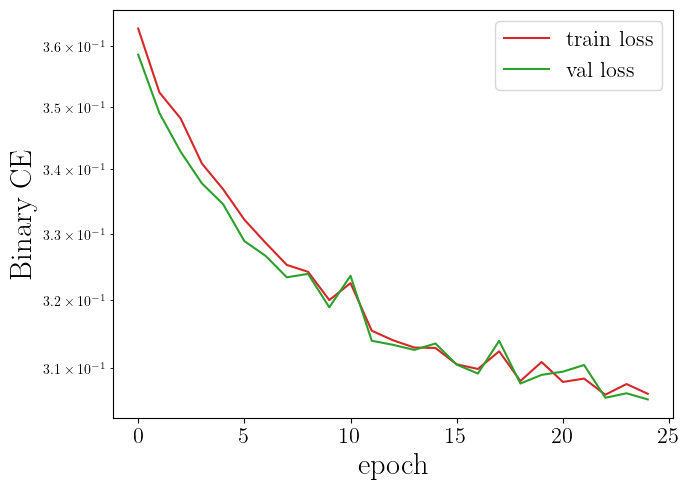

In [35]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses, label="train loss", color=c1 )
axs.plot( val_losses, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "Binary CE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

In [36]:
trn_loss = trn_pass( train_cnn_dataloader, model, loss_fn )
val_loss = val_pass( test_cnn_dataloader, model, loss_fn )
test_loss = val_pass( val_cnn_dataloader, model, loss_fn )

separator()
print("Final evaluation of performance:")
print("MSE-loss on train dataset: {}".format(trn_loss))
print("MSE-loss on validation dataset: {}".format(val_loss))
print("MSE-loss on test dataset: {}".format(test_loss))
separator()

avg trn loss per batch: 0.306328
avg val loss per batch: 0.312994
avg val loss per batch: 0.305620
-----------------------------------------------
Final evaluation of performance:
MSE-loss on train dataset: 0.30632780276254806
MSE-loss on validation dataset: 0.3129940018026051
MSE-loss on test dataset: 0.3056195008475135
-----------------------------------------------


However, these numbers don't show clearly what's the performance of our model.

Let's try with the accuracy: $\frac{\mathbf{correct}}{\mathbf{total}}\cdot100$

In [37]:
samp_size = 10000

train_pred = model(z_train[:samp_size].to(device)).detach()
test_pred = model(z_test[:samp_size].to(device)).detach()
val_pred = model(z_val[:samp_size].to(device)).detach()

train_pred_lab = torch.round(train_pred[:samp_size])
test_pred_lab = torch.round(test_pred[:samp_size])
val_pred_lab = torch.round(val_pred[:samp_size])

train_correct = (train_pred_lab==y_train[:samp_size].to(device)).sum().item()
test_correct = (test_pred_lab==y_test[:samp_size].to(device)).sum().item()
val_correct = (val_pred_lab==y_val[:samp_size].to(device)).sum().item()

In [38]:
separator()
print('Evaluation of accuracy: ')
print('Accuracy on training dataset: {:.1f} %'.format(train_correct*100/len(train_pred)))
print('Accuracy on validation dataset: {:.1f} %'.format(val_correct*100/len(val_pred)))
print('Accuracy on test dataset: {:.1f} %'.format(test_correct*100/len(test_pred)))
separator()

-----------------------------------------------
Evaluation of accuracy: 
Accuracy on training dataset: 87.0 %
Accuracy on validation dataset: 88.0 %
Accuracy on test dataset: 86.9 %
-----------------------------------------------


Good accuracy for a really simple model!

## Study the results - plot the ROC curve

One possible way to study our results is to plot a ROC curve. This is created by plotting the True Positive Rate against the False Positive Rate at different thresholds.TPR and FPR are defined by:

- TPR = $\frac{TP}{TP+FN}$;
- FPR = $\frac{FP}{FP+TN}$,

namely the probability of correctly identyfing a signal against the probability of falsely rejecting a background event.

When dealing with a background/signal test, it's usual to call the TPR signal efficiency and the FPR background rejection.

Once we plot the ROC curve, we would like to quantify the performance according to some criteria.
Two indices are mainly used:
- AUC score, which is the Area Under the Curve;
- Inverse mistag at low efficiency (e.g. 0.3)

The AUC represents the probability of a random signal sample to have higher score than a background event.
The inverse mistag hasn't a probabilistic interpretation, but higher values denote a better sensitivity to signal events.

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score

def closest_point(array, tpr_p=0.3):
    dist = ((array-tpr_p)**2)
    return np.argmin(dist)

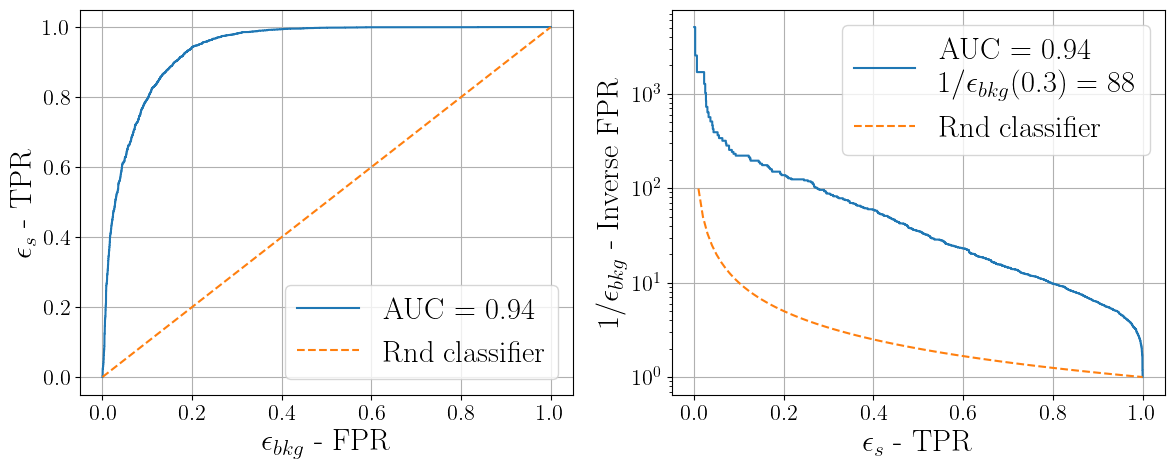

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
test_true_lab=y_test[:samp_size]

fpr, tpr, th = roc_curve(test_true_lab, test_pred.to('cpu'))#[:,1])
auc_score = roc_auc_score(test_true_lab, test_pred.to('cpu'))
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

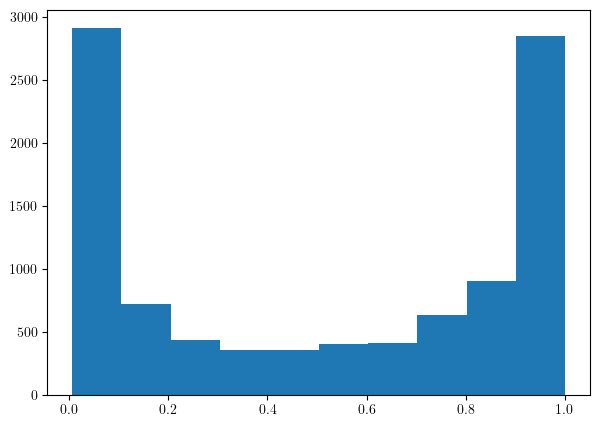

In [41]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.hist(test_pred[:,0].cpu())
plt.show()

## CNNs and translation invariance

The convolution operation is <ins>**not**</ins> translation invariant but **equivariant**. what does that mean?
Translation equivariant means that a translated input is mapped to the translated output, in formula:

$f(x(t)) = y(t)$ &#10230; $f(x(t+s)) = y(t+s)$,

while a translation invariant operation implies:

$f(x(t)) = y(t)$ &#10230; $f(x(t+s)) = y(t)$.

Nevertheless, we can check that the network is still invariant to small translation of the input datasets. Let's shift the test dataset in the vertical and horizontal axis:

In [42]:
test_h = torch.roll(z_test, 3, dims=3)
test_v = torch.roll(z_test, 3, dims=2)

Now check the accuracy of the previously trained model:

In [43]:
samp_size = 10000

test_pred = model(z_test[:samp_size].to(device)).detach()
test_pred_h = model(test_h[:samp_size].to(device)).detach()
test_pred_v = model(test_v[:samp_size].to(device)).detach()

test_pred_lab = torch.round(test_pred[:samp_size])
test_pred_lab_h = torch.round(test_pred_h[:samp_size])
test_pred_lab_v = torch.round(test_pred_v[:samp_size])

test_cor = (test_pred_lab==y_test[:samp_size].to(device)).sum().item()
test_cor_h = (test_pred_lab_h==y_test[:samp_size].to(device)).sum().item()
test_cor_v = (test_pred_lab_v==y_test[:samp_size].to(device)).sum().item()

In [44]:
separator()
print('Accuracy on shifted datasets:')
print('No-shifts: {:.1f} %'.format(test_cor*100/len(test_pred)))
print('Vertical shift: {:.1f} %'.format(test_cor_h*100/len(test_pred_h)))
print('Horizontal shift: {:.1f} %'.format(test_cor_v*100/len(test_pred_v)))
separator()

-----------------------------------------------
Accuracy on shifted datasets:
No-shifts: 86.9 %
Vertical shift: 60.7 %
Horizontal shift: 80.2 %
-----------------------------------------------


- #### Why there's some translation invariance? Why will it be broken at some point?

max-pooling layer reduces the dependence on the spatial positioning. 

At large shifts we'll drastically change the physics of the jet (especially for tops), pooling doesn't help anymore, and linear layers are definitely not translation invariant.


## CNNs vs FCNs

How many parameters does a CNN have?

*output_channels* * (*input_channels* * *kernel_width* * *kernel_height* + 1)

How many parameters does a FCN have?

*output_nodes* * (input_nodes + 1)

In our case we have 104 parameters from the first convolution, 100 from the second one, and 101 from the linear layer (no learnable weights in max-pooling and flattening), thus:

**CNN parameters**: ~300

Let's try to build a FCN with similar number of weights. The simplest network has just one layer that maps the pixels into a probability output.
So, in the simplest case, we already have a number of parameters equal to the number of pixels.

**FCN parameters** (simplest case): ~1600

Let's try to train this FCN.

In [45]:
#cnn parameters:  104, 100, 101 -> 300
#smallest fcn has at least 1600 params

class FullyConnected(nn.Module):
    
    def __init__(self, img_pixels=1600, out_dim=1):
        super().__init__()
        self.linear1 = nn.Linear(img_pixels, out_dim, bias=True)
    
    def forward(self, x):
        self.net = nn.Sequential(
            nn.Flatten(),
            self.linear1,
            nn.Softmax()
        )
        return self.net(x)

In [46]:
epochs = 50
loss_fn = nn.BCELoss()

# re-initialise the model and the optimizer
model = FullyConnected().to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( train_cnn_dataloader, model, loss_fn, optimizer )
    separator()
    trn_loss = trn_pass( train_cnn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_cnn_dataloader, model, loss_fn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
FullyConnected(
  (linear1): Linear(in_features=1600, out_features=1, bias=True)
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 56.250000  [    0/30000]
current batch loss: 62.500000  [ 6400/30000]
current batch loss: 56.250000  [12800/30000]
current batch loss: 51.562500  [19200/30000]
current batch loss: 53.125000  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 49.872290
-----------------------------------------------
avg val loss per batch: 48.204291
-----------------------------------------------
|
-----------------------------------------------
Epoch 2
-----------------------------------------------
current batch loss: 51.562500  [    0/30000]
current batch loss: 51.562500  [ 6400/30000]
current batch loss: 46.875000  [12800/30000]
current batch loss:

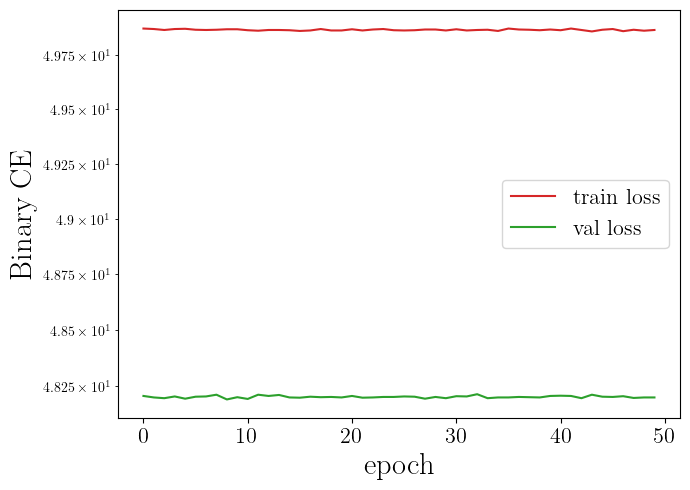

In [47]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses, label="train loss", color=c1 )
axs.plot( val_losses, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "Binary CE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

In [48]:
trn_loss = trn_pass( train_cnn_dataloader, model, loss_fn )
val_loss = val_pass( test_cnn_dataloader, model, loss_fn )
test_loss = val_pass( val_cnn_dataloader, model, loss_fn )

separator()
print("Final evaluation of performance:")
print("MSE-loss on train dataset: {}".format(trn_loss))
print("MSE-loss on validation dataset: {}".format(val_loss))
print("MSE-loss on test dataset: {}".format(test_loss))
separator()

avg trn loss per batch: 49.867848
avg val loss per batch: 50.275409
avg val loss per batch: 48.194296
-----------------------------------------------
Final evaluation of performance:
MSE-loss on train dataset: 49.867848264128924
MSE-loss on validation dataset: 50.27540868177597
MSE-loss on test dataset: 48.194296375266525
-----------------------------------------------


In [49]:
samp_size = 10000

train_pred = model(z_train[:samp_size].to(device)).detach()
test_pred = model(z_test[:samp_size].to(device)).detach()
val_pred = model(z_val[:samp_size].to(device)).detach()

train_pred_lab = torch.round(train_pred[:samp_size])
test_pred_lab = torch.round(test_pred[:samp_size])
val_pred_lab = torch.round(val_pred[:samp_size])

train_correct = (train_pred_lab==y_train[:samp_size].to(device)).sum().item()
test_correct = (test_pred_lab==y_test[:samp_size].to(device)).sum().item()
val_correct = (val_pred_lab==y_val[:samp_size].to(device)).sum().item()

In [50]:
separator()
print('Evaluation of accuracy: ')
print('Accuracy on training dataset: {:.1f} %'.format(train_correct*100/len(train_pred)))
print('Accuracy on validation dataset: {:.1f} %'.format(val_correct*100/len(val_pred)))
print('Accuracy on test dataset: {:.1f} %'.format(test_correct*100/len(test_pred)))
separator()

-----------------------------------------------
Evaluation of accuracy: 
Accuracy on training dataset: 50.8 %
Accuracy on validation dataset: 52.4 %
Accuracy on test dataset: 49.2 %
-----------------------------------------------


## Over-training?  Solutions?

Did you mean over-fitting? 

Convolutions reduce over-fitting as we can see in the cnn vs fcn.  why? (weights sharing, invariance, less parameters)

## How could we improve the results?

with a larger model:
- mora channels;
- more convolutions;
- smaller filters;

with larger training dataset (at least 100000 imgs)

... else?